# Let's train some models so we can deploy

## Setup helper function

In [ ]:
# Create a function to read the lines of document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictonaries of abstract line data.

  Takes in filename, reads some content and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  """
  
  input_lines = get_lines(filename) # get all of the line
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line on the target file 
  for line in input_lines: 
    # 1. Start
    if line.startswith("###"): # check to see if this an ID line
      abstract_id = line # put the id to variable
      abstract_lines = "" # reset the abstract string if the line is an ID line

    # 3.End (split input_lines into individual abstract and store on dict)
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines and turn `abstract_lines` into list (see above instruction)

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split): # KEYNOTE: split into individual line on each abstract

        target_text_split = abstract_line.split('\t') # split target label from text

        # Create dictionary and put it into list
        line_data = {} # create an empty dictionary for each line
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from zero)
        abstract_samples.append(line_data) # add line data to abstract samples list

    # 2.Add line to abstract_lines
    else: # if the above condition doesn't fulfilled, the line contains a labelled sentence
      abstract_lines += line
   
  return abstract_samples

In [ ]:
# Get the evaluation function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results, create_tensorboard_callback

--2023-02-10 05:22:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-10 05:22:54 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Model Checkpoint
def create_MC(model_name, save_path="model_experiments", monitor="val_loss", save_best_only=True):
  return ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0, 
                                            monitor=monitor,
                                            save_best_only=save_best_only) # save only the best model to file


## Preprocess data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# Start our experiments using the 20K dataset with number replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

# Turn it into dataframes so we can visualize it later
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.65 MiB/s, done.


(180040, 30212, 30135)

## Get numeric labels
1. One hot encoded labels
2. Label encoded labels

In [ ]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix bcz tensorflow is uncompatible with non_sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # dont need `fit` bcz it has been learned the data structure on code above
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Label encoded labels 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

## Token Level 
Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## Character Level
1. Turn the sequence-level data into character level data
1. Create character level vectorization
2. Create character level embedding


In [ ]:
from tensorflow.keras.layers import TextVectorization
import string

# 1. Sequence to char
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# 2. Char level vectorizer

# What's the average character length? 
char_lens = [len(sentence) for sentence in train_sentences]
# Find what character length cover 95% sequence
output_seq_char_len = int(np.percentile(char_lens, 95))

# Setup parameter
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, "[UNK]")

# Create char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standarization to "None" if you want to leave punctuation in 
                                    name="char_vectorizer")
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)
train_chars_vectorized = char_vectorizer(train_chars) 
val_chars_vectorized =  char_vectorizer(val_chars)


# 3. Character Embedding
# Check character vocab stats (with standardization "lower_and_strip_punctuation")
char_vocab = char_vectorizer.get_vocabulary() #
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters = 28
                                            output_dim=25, # this is the size of the char embedding in this paper: https://arxiv.org/abs/1710.06071
                                            mask_zero=True,
                                            name="char_embedding")

In [ ]:
char_vectorized = char_vectorizer(train_chars[0])
char_embedded = char_embed(char_vectorized)
char_embed

<tf.Tensor: shape=(290, 25), dtype=float32, numpy=
array([[-0.03553053,  0.02089223,  0.03742368, ...,  0.0350137 ,
        -0.02664833, -0.02898328],
       [-0.03436679, -0.04573923, -0.03835653, ...,  0.03913094,
        -0.02933549,  0.01077689],
       [ 0.04860355,  0.00900036, -0.04091841, ...,  0.01161609,
        -0.03912392, -0.02860714],
       ...,
       [-0.00065296,  0.00458773,  0.02789311, ..., -0.03081719,
        -0.01604785,  0.01601217],
       [-0.00065296,  0.00458773,  0.02789311, ..., -0.03081719,
        -0.01604785,  0.01601217],
       [-0.00065296,  0.00458773,  0.02789311, ..., -0.03081719,
        -0.01604785,  0.01601217]], dtype=float32)>

## Create positional embeddings
1. Line number
2. Total lines

> 🔑 **Note:** Any enggineered features used to train a model need to be available at test time, in our case line numbers and total lines are available

In [ ]:
# One-hot encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15) # 15 bcz it covered 95% percent of line-number
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# One-hot-encoded tensor of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


Model 9:

## Model 1: Transfer learning with pretrained token embeddings and character embeddings + positional embeddings

We're going to use `3 features` to predict `1 label` 

### Create tribid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars_vectorized))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars_vectorized))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Building a tribrid embedding model

1. Create token-level model
2. Create character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create output layer to accept that tribrid embedding and output label probabilities
8. Combine the inputs 1, 2, 3, 4 and outputs of into tf.keras.Model

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(290,), dtype=tf.float32,  name="char_inputs") # 1 sequence shape
char_embeddings = char_embed(char_inputs)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_1 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="tribrid_model")
# Same model for all data training 
model_1_all_data = tf.keras.models.clone_model(model_1)

In [ ]:
# Compile token,char and positional embedding model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our tribrid embedding model
model_1_history = model_1.fit(train_char_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
            epochs=3,
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
            callbacks=[create_tensorboard_callback("tensorboard", "tribrid_model.h5")])

Saving TensorBoard log files to: tensorboard/skimlit_tribrid_model.h5/20230111-112638
Epoch 1/3


KeyboardInterrupt: ignored

In [ ]:
# Plot model_1 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_1)

In [ ]:
# Make predictions with char token pos model
model_1_pred_probs = model_1.predict(val_char_token_pos_dataset)
model_1_pred_probs[:5]

In [ ]:
# Convert pred probs into to label
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

In [ ]:
# Calculate results of char token pos model
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

### Save and Load Model
Make sure that we be able to export our model.

In [ ]:
# Save the model 1 to Google Drive
model_1.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/skimlit_tribrid_model.h5")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/tribrid_model.h5",  custom_objects={"KerasLayer": hub.KerasLayer}  )

In [ ]:
# Make predictions with char token pos model
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)

loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=loaded_model_preds)

loaded_model_results

### Train the model on all data 

In [ ]:
# # # Compile token,char and positional embedding model
# model_1_all_data.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# # Fit our tribrid embedding model
model_1_all_data_history = model_1_all_data.fit(train_char_token_pos_dataset,
            epochs=1000,
            validation_data=val_char_token_pos_dataset,
            callbacks=[create_tensorboard_callback("tensorboard", "tribrid_model_all_data"),
                       tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                       tf.keras.callbacks.ModelCheckpoint(filepath="model_experiments/tribrid_model_all_data.h5", save_best_only=True)])

In [ ]:
# Make predictions with char token pos model
model_1_all_data_pred_probs = model_1_all_data.predict(val_char_token_pos_dataset)
model_1_all_data_preds = tf.argmax(model_1_all_data_pred_probs, axis=1)
model_1_all_data_results = calculate_results(model_1_all_data_preds, val_char_token_pos_labels)
model_1_all_data_results

In [ ]:
model_all_data.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/tribrid_model_all_data.h5")

## Model 2: Hybrid (pretrained token + positional)

In [ ]:
# Create training and validation datasets
train_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences))

train_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_pos_dataset = tf.data.Dataset.zip((train_token_pos_data, train_token_pos_labels))

train_token_pos_dataset = train_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences))
val_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_pos_dataset = tf.data.Dataset.zip((val_token_pos_data, val_token_pos_labels))

val_token_pos_dataset = val_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)


# 2. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# Combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 3. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 4. Combine positional embedding with combined token into a hybrid embeddings
hybrid_embeddings = layers.Concatenate(name="token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 token_model.output])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(hybrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_2 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input],
                          outputs=output_layer,
                         name="hybrid_model")

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [ ]:
# Compile token and positional embedding model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our hybrid embedding model
model_2_history = model_2.fit(train_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_token_pos_dataset)),
            epochs=3,
            validation_data=val_token_pos_dataset,
            validation_steps=int(0.1 * len(val_token_pos_dataset)),
            callbacks=[create_tensorboard_callback("tensorboard", "hybrid_model")])

In [ ]:
# Make predictions with char token pos model
model_2_pred_probs = model_2.predict(val_token_pos_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

# Calculate results of char token pos model
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

In [ ]:
model_2.save("hybrid_model.h5")

As you can see, eventhough our overall result is **1.5 lower than the tribrid model**. Our training is still faster which takes **about 28 second rather than 80 second**

## Model 3: Hybrid with mixed precision

In [ ]:
# Change the global policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

mixed_precision.global_policy()

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)


# 2. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# Combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 3. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 4. Combine positional embedding with token embeddings  into a hybrid embeddings
hybrid_embeddings = layers.Concatenate(name="token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 token_model.output])
# 5. Create output layer
output_layer = layers.Dense(5,name="output_layer")(hybrid_embeddings)
output_activation = layers.Activation("softmax", dtype=tf.float32)(output_layer)

# 6. Put together all model with all kinds of inputs
model_3 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input],
                          outputs=output_layer,
                         name="hybrid_mixed_precision_model")

In [ ]:
for layer in model_3.layers:
  print(layer.dtype_policy)

In [ ]:
# Compile token and positional embedding model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our tribrid embedding model
model_3_history = model_3.fit(train_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_token_pos_dataset)),
            epochs=10,
            validation_data=val_token_pos_dataset,
            validation_steps=int(0.1 * len(val_token_pos_dataset)),
            callbacks=[create_tensorboard_callback("tensorboard", "hybrid_mixed_precision_model.h5")])

In [ ]:
# Make predictions with char token pos model
model_3_pred_probs = model_3.predict(val_token_pos_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Calculate results of char token pos model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

In [ ]:
model_3.save("hybrid_mixed_precision_model.h5")

Mixed precision model has returned a **lower score** and the model size is **still big**

## Model 10: Bert with hub.load



In [ ]:
# Dependencies
!pip install --quiet tensorflow-text==2.9.0 # specify version to avoid error

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
from tensorflow.keras import layers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 49.7 MB/s eta 0:00:00


In [ ]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [ ]:
preprocessor = hub.KerasLayer(preprocess, name='pubmed_bert_preprocessor')
bert = hub.KerasLayer(bert, name="bert_layer")

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars_vectorized))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot , # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars_vectorized))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(290,), dtype=tf.float32,  name="char_inputs") # 1 sequence shape
char_embeddings = char_embed(char_inputs)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_9 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="bert_tribrid_model_hub_load")

In [ ]:
# Compiling and fitting the model (Fun Part!)
model_9.compile(loss= tf.keras.losses.CategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Train only on 10% of data
model_9.fit(train_char_token_pos_dataset , 
                 steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)), 
                 epochs = 1, 
                 validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                 validation_data = val_char_token_pos_dataset,
                 callbacks = [create_tensorboard_callback("tensorboard", "bert_tribrid_model_hub_load" )]
                 )

Saving TensorBoard log files to: tensorboard/bert_tribrid_model_hub_load/20230207-114724
562/562 [==============================] - 262s 447ms/step - loss: 0.8356 - accuracy: 0.6545 - val_loss: 0.6065 - val_accuracy: 0.7434


In [ ]:
model_9.save(f"/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_tribrid_model_hub_load.h5")

## Model 11 : Bert with text vectorization inside



In [ ]:
# Dependencies
!pip install --quiet tensorflow-text==2.9.0 # specify version to avoid error

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
from tensorflow.keras import layers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.8 MB/s eta 0:00:00


In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot , # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_10 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="bert_tribrid_model_hub_load")

In [ ]:
# Compiling and fitting the model (Fun Part!)
model_10.compile(loss= tf.keras.losses.CategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Train only on 10% of data
model_10.fit(train_char_token_pos_dataset , 
                 steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)), 
                 epochs = 1, 
                 validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                 validation_data = val_char_token_pos_dataset,
                 callbacks = [create_tensorboard_callback("tensorboard", "bert_tribrid_model_hub_load" )]
                 )

Saving TensorBoard log files to: tensorboard/bert_tribrid_model_hub_load/20230207-115326
562/562 [==============================] - 262s 436ms/step - loss: 0.7532 - accuracy: 0.7314 - val_loss: 0.4737 - val_accuracy: 0.8231


In [ ]:
model_10.save(f"/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_tribrid_model_char_vectorizer")

## Model 4: Bert pubmed token embeddings
**Resources📖:**
- Detail about Bert Pubmed Expert - https://tfhub.dev/google/experts/bert/pubmed/2
- Detail on preprocessing step - "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

In [ ]:
# Dependencies
!pip3 install --quiet tensorflow-text==2.9.0 # specify version to avoid error

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
from tensorflow.keras import layers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.8 MB/s eta 0:00:00


In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

In [ ]:
# Demonstration of bert layer
sentences = ["Hello world, my name is vincent jonathan. So i am going to examine a problem about why we should eat breakfast?"]
bert_inputs = preprocessor(sentences)
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs["pooled_output"]
x = layers.Dense(128, "relu")(pooled_output)
output_layer = layers.Dense(5, "softmax")(x)

print(output_layer)

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

model_4 = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs,
                             name="bert_token_model")


In [ ]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit feature extractor model for 3 epochs
model_4.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_steps=int(0.1 * len(valid_dataset)),
            validation_data=valid_dataset,
            callbacks=[create_tensorboard_callback("tensorboard", "bert_token_model")])

In [ ]:
model_4_pred_probs = model_4.predict(valid_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

In [ ]:
model_4.save("bert_token_model_4.h5")

## New feature : line number total features


In [ ]:
# Combining the total lines and line number into a new feature! 
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)

train_df.head()

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11


In [ ]:
# Creating an instance 
one_hot_encoder = OneHotEncoder(sparse=False) # dont transform into sparse object

train_line_number_total_encoded  = one_hot_encoder.fit_transform(train_df["line_number_total"].to_numpy().reshape(-1, 1)).astype("float32") # expand the dims then turn it into float32
val_line_number_total_encoded  = one_hot_encoder.transform(val_df["line_number_total"].to_numpy().reshape(-1, 1)).astype("float32")

train_line_number_total_encoded.shape, val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

## Model 5: Bert pubmed tribrid

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_total_encoded, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars_vectorized))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_total_encoded , # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars_vectorized))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

NameError: ignored

In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(290,), dtype=tf.float32,  name="char_inputs") # 1 sequence shape
char_embeddings = char_embed(char_inputs)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(460,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_5 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="bert_tribrid_model_new_feature")

In [ ]:
# Compiling and fitting the model (Fun Part!)
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Train only on 10% of data
model_5.fit(train_char_token_pos_dataset , 
                 steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)), 
                 epochs = 3 , 
                 validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                 validation_data = val_char_token_pos_dataset,
            )

In [ ]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

In [ ]:
model_5.save("tribrid_model.h5")

## Model 6: Bert pubmed tribrid (old feature)

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars_vectorized))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot , # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars_vectorized))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 290), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(290,), dtype=tf.float32,  name="char_inputs") # 1 sequence shape
char_embeddings = char_embed(char_inputs)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_6 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="bert_tribrid_model")

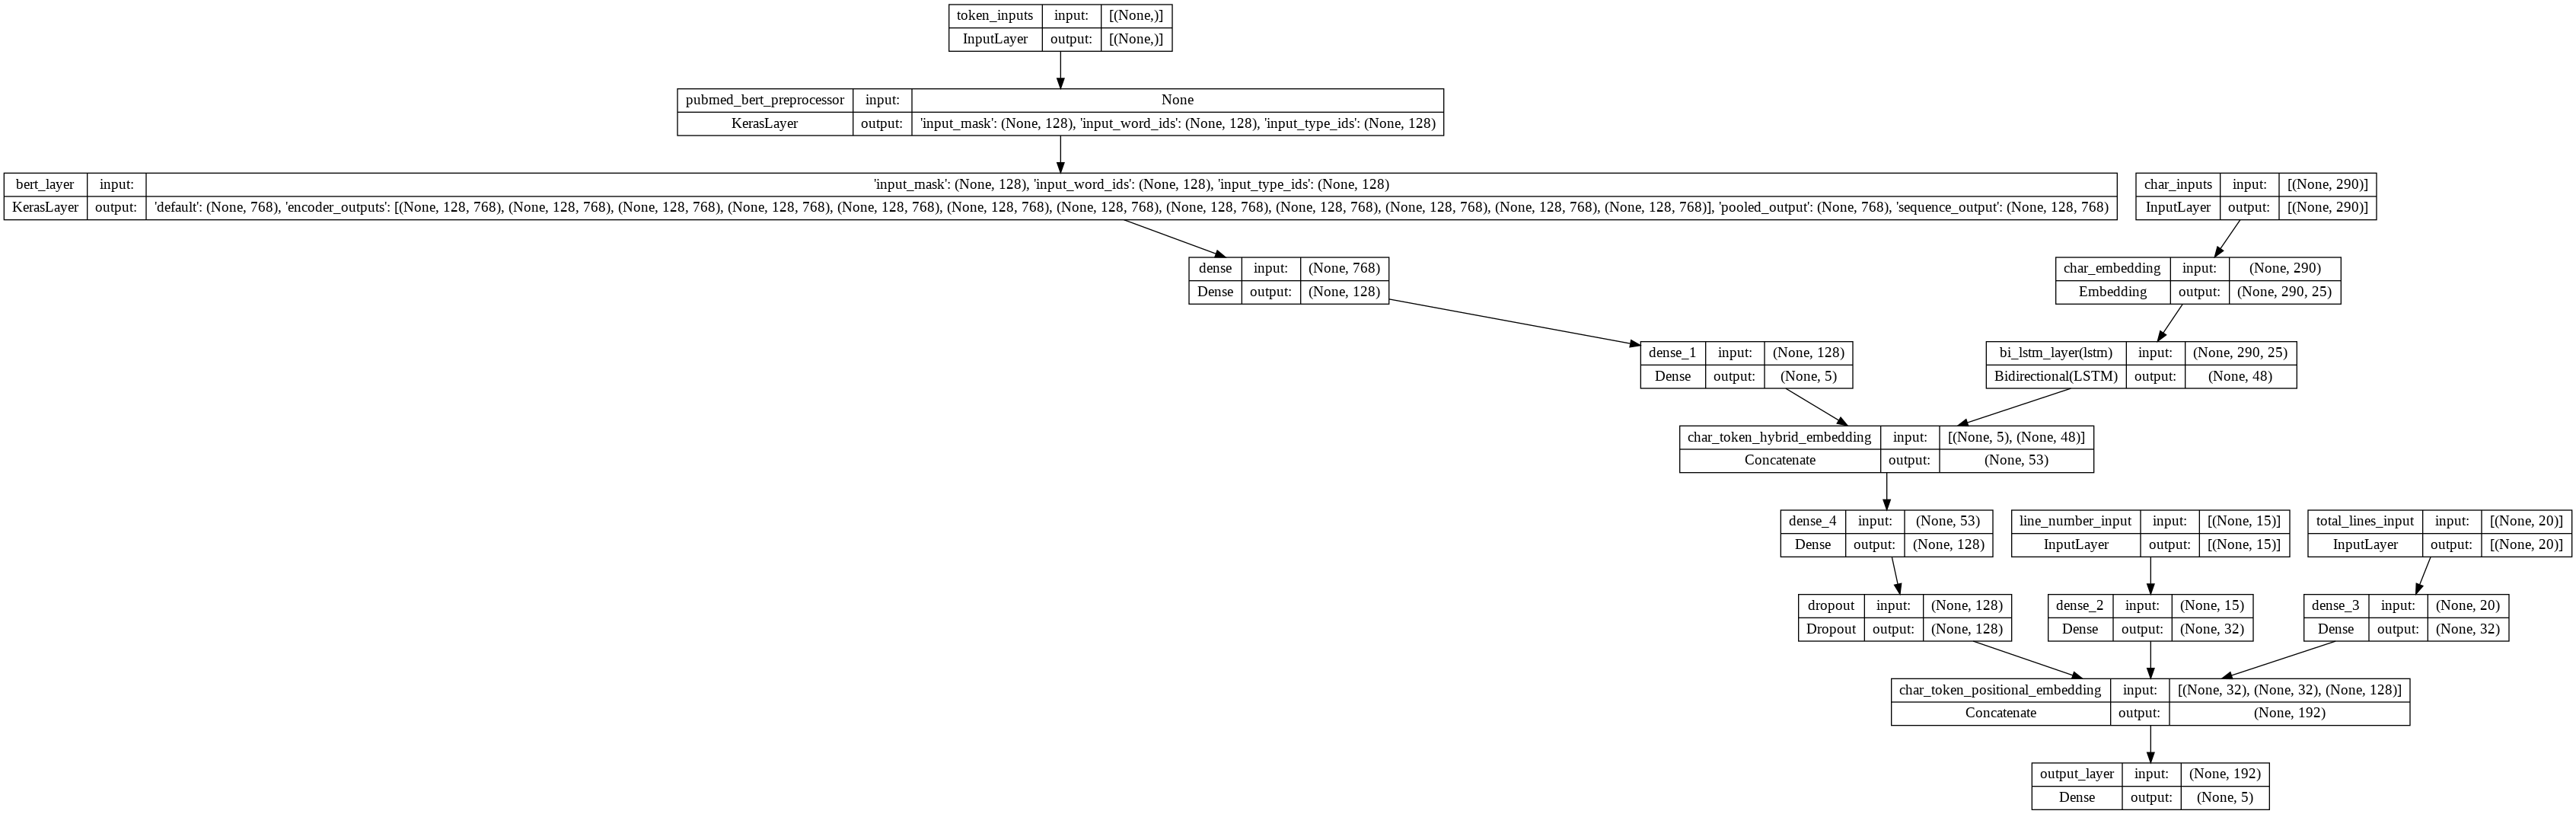

In [ ]:

tf.keras.utils.plot_model(model_6,show_shapes=True)

In [ ]:
# Compiling and fitting the model (Fun Part!)
model_6.compile(loss= tf.keras.losses.CategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Train only on 10% of data
model_6.fit(train_char_token_pos_dataset , 
                 steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)), 
                 epochs = 3, 
                 validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                 validation_data = val_char_token_pos_dataset,
                 callbacks = [create_tensorboard_callback("tensorboard", "bert_tribrid_model" )]
                 )

Saving TensorBoard log files to: tensorboard/bert_tribrid_model/20230116-110745
Epoch 1/3
562/562 [==============================] - 253s 414ms/step - loss: 0.7213 - accuracy: 0.7384 - val_loss: 0.4881 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 233s 414ms/step - loss: 0.4554 - accuracy: 0.8366 - val_loss: 0.3995 - val_accuracy: 0.8441
Epoch 3/3
562/562 [==============================] - 230s 409ms/step - loss: 0.3943 - accuracy: 0.8602 - val_loss: 0.3444 - val_accuracy: 0.8690


In [ ]:
# Make predictions with char token pos model
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

# Calculate results of char token pos model
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

945/945 [==============================] - 312s 330ms/step


{'accuracy': 87.33615781808552,
 'precision': 0.8720829117093545,
 'recall': 0.8733615781808552,
 'f1': 0.8724008927052875}

In [ ]:
model_6.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_tribrid_model")

## Model 7: Bert pubmed hybrid

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_total_encoded, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences))

train_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_pos_dataset = tf.data.Dataset.zip((train_token_pos_data, train_token_pos_labels))

train_token_pos_dataset = train_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_total_encoded, # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences))
val_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_pos_dataset = tf.data.Dataset.zip((val_token_pos_data, val_token_pos_labels))

val_token_pos_dataset = val_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(460,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 3. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)


# 4. Combine positional embedding with token embedding into a hybrid embeddings
hybrid_embeddings = layers.Concatenate(name="token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 token_model.output])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(hybrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_7 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input],
                          outputs=output_layer,
                         name="bert_hybrid_model_new_feature")

In [ ]:
# Compile token and positional embedding model
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our tribrid embedding model
model_7_history = model_7.fit(train_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_token_pos_dataset)),
            epochs=3,
            validation_data=val_token_pos_dataset,
            validation_steps=int(0.1 * len(val_token_pos_dataset)),
            callbacks=[create_tensorboard_callback("tensorboard", "bert_hybrid_model_new_feature")])

In [ ]:
# Make predictions with char token pos model
model_7_pred_probs = model_8.predict(val_token_pos_dataset)
model_7_preds = tf.argmax(model_8_pred_probs, axis=1)

# Calculate results of char token pos model
model_7_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_8_preds)
model_7_results

In [ ]:
model_7.save("bert_hybrid_model_new_feature.h5")

## Model 8: Bert pubmed hybrid (old feature)

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                train_total_lines_one_hot,
                                                                train_sentences))

train_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_pos_dataset = tf.data.Dataset.zip((train_token_pos_data, train_token_pos_labels))

train_token_pos_dataset = train_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # the order same as how we construct model_1 above
                                                                val_total_lines_one_hot,
                                                                val_sentences))
val_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_pos_dataset = tf.data.Dataset.zip((val_token_pos_data, val_token_pos_labels))

val_token_pos_dataset = val_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load the BERT encoder and preprocessing models and wrap it as KerasLayer
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'pubmed_bert_preprocessor')
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', name="bert_layer")

# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
bert_inputs = preprocessor(token_inputs)
# Feed the inputs to the model to get the pooled 
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output'] # take the  most importance features from sequence output
x = layers.Dense(128, activation="relu")(pooled_output)
token_outputs = layers.Dense(5, activation="softmax")(x)

token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 3. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)


# 4. Combine positional embedding with token embedding into a hybrid embeddings
hybrid_embeddings = layers.Concatenate(name="token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 token_model.output])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(hybrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_8 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input],
                          outputs=output_layer,
                         name="bert_hybrid_model")

In [ ]:
# Compile token and positional embedding model
model_8.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our tribrid embedding model
model_8_history = hybrid_old_bert_model.fit(train_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_token_pos_dataset)),
            epochs=3,
            validation_data=val_token_pos_dataset,
            validation_steps=int(0.1 * len(val_token_pos_dataset)),
            callbacks=[create_tensorboard_callback("tensorboard", "bert_hybrid_model")])

Saving TensorBoard log files to: tensorboard/bert_old_hybrid_model/20230112-222051
Epoch 1/3
562/562 [==============================] - 226s 381ms/step - loss: 1.1839 - accuracy: 0.6795 - val_loss: 1.0026 - val_accuracy: 0.7876
Epoch 2/3
562/562 [==============================] - 224s 400ms/step - loss: 0.9678 - accuracy: 0.8092 - val_loss: 0.9434 - val_accuracy: 0.8135
Epoch 3/3
562/562 [==============================] - 214s 380ms/step - loss: 0.9308 - accuracy: 0.8238 - val_loss: 0.9083 - val_accuracy: 0.8331


In [ ]:
# Make predictions with char token pos model
model_8_pred_probs = model_8.predict(val_token_pos_dataset)
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)

# Calculate results of char token pos model
model_8_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_8_preds)
model_8_results

945/945 [==============================] - 305s 322ms/step


{'accuracy': 83.5495829471733,
 'precision': 0.8306441674150209,
 'recall': 0.8354958294717331,
 'f1': 0.8323967135786566}

In [ ]:
model_8.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_hybrid_model")

# All Model Results

In [ ]:
tribrid_model = {'accuracy': 82.8975241625844,
 'precision': 0.8277694784501003,
 'recall': 0.828975241625844,
 'f1': 0.828015129987685}

tribrid_model_all_data = {'accuracy': 85.78710446180325,
 'precision': 0.8598174539198177,
 'recall': 0.8578710446180325,
 'f1': 0.8550776919466074}

hybrid_model = {'accuracy': 81.58678670726863,
'precision': 0.8149824948217776,
'recall': 0.8158678670726863,
'f1': 0.8149727263506357}

hybrid_mixed_precision_model = {'accuracy': 0.36409373758771346,
 'precision': 0.004693009375125171,
 'recall': 0.003640937375877135,
 'f1': 0.003193448507916884}

bert_token_model =  {'accuracy': 85.07215675890374,
 'precision': 0.852976913964775,
 'recall': 0.8507215675890375,
 'f1': 0.8509176234650548}

bert_tribrid_model_new_feature = {'accuracy': 88.33245068184827,
 'precision': 0.8826089976447627,
 'recall': 0.8833245068184827,
 'f1': 0.882147433028216}

bert_tribrid_model = {'accuracy': 87.48841519925857,
 'precision': 0.8747755562837839,
 'recall': 0.8748841519925857,
 'f1': 0.8739759836061868}

bert_hybrid_model_new_feature = {'accuracy': 84.60545478617767,
 'precision': 0.8403932097000814,
 'recall': 0.8460545478617768,
 'f1': 0.8418836005832272}

bert_hybrid_model = {'accuracy': 83.5495829471733,
 'precision': 0.8306441674150209,
 'recall': 0.8354958294717331,
 'f1': 0.8323967135786566}


In [ ]:
import pandas as pd
results_df = pd.DataFrame({"tribrid_model":tribrid_model,
                          "tribrid_model_all_data":tribrid_model_all_data,
                           "hybrid_model":hybrid_model,
                           "hybrid_mixed_precision_model":hybrid_mixed_precision_model,
                           "bert_token_model":bert_token_model,
                           "bert_tribrid_model_new_feature":bert_tribrid_model_new_feature,
                           "bert_tribrid_model":bert_tribrid_model,
                           "bert_hybrid_model":bert_hybrid_model_new_feature,
                           "bert_hybrid_model":bert_hybrid_model}).T
# Reduce the accuracy to same scale as other metrics
results_df["accuracy"] = results_df["accuracy"]/100
results_df

,accuracy,precision,recall,f1
tribrid_model,0.828975,0.827769,0.828975,0.828015
tribrid_model_all_data,0.857871,0.859817,0.857871,0.855078
hybrid_model,0.815868,0.814982,0.815868,0.814973
hybrid_mixed_precision_model,0.003641,0.004693,0.003641,0.003193
bert_token_model,0.850722,0.852977,0.850722,0.850918
bert_tribrid_model_new_feature,0.883325,0.882609,0.883325,0.882147
bert_tribrid_model,0.874884,0.874776,0.874884,0.873976
bert_hybrid_model,0.835496,0.830644,0.835496,0.832397


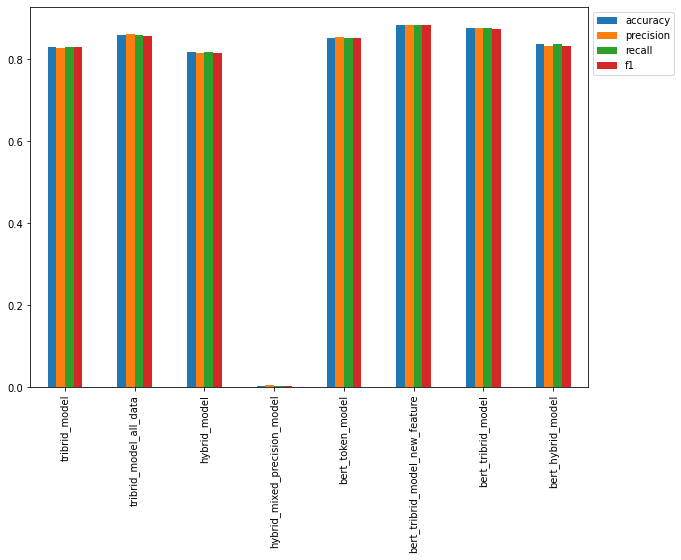

In [ ]:
# Plot and compare all of the model results
results_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Text Predictions with Bert Tribrid

In [ ]:
import spacy

# Function to get abstract line information
def preprocess_text_with_line_numbers(abstract_text):
  
  nlp = spacy.load("en_core_web_sm") # setup english sentence parser 
  doc = nlp(abstract_text) # create "doc" of parsed sequences
  abstract_lines = [str(sent) for sent in list(doc.sents)] # list of line on string (not spaCy type)

  # Create list of dictionaries containing features for each line
  total_lines_in_sample = len(abstract_lines) # get total number of lines 

  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i 
    sample_dict['total_lines'] = total_lines_in_sample - 1 
    sample_lines.append(sample_dict)   
      
  return sample_lines

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Function to vectorized character sentence
import string
from tensorflow.keras.layers import TextVectorization

def char_vectorization(chars):
  # Define the parameter
  alphabet = string.ascii_lowercase + string.digits + string.punctuation
  NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, "[UNK]")
  output_sequence_length = 290 # same as the model trained on

  # Instantiate TextVectorizer
  char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                      output_sequence_length=output_sequence_length)
  char_vectorizer.adapt(chars) # learn the pattern on data

  chars_vectorized = char_vectorizer(chars)

  return chars_vectorized

import pandas as pd
# Full preprocess function
def preprocessor(abstract_text):
  sample = preprocess_text_with_line_numbers(abstract_text) 
  df = pd.DataFrame(sample)
  # Sentence and character level
  sentences = df["text"].tolist()
  chars = [split_chars(sentence) for sentence in sentences]
  chars_vectorized = char_vectorization(chars)
  # Positional embeddings
  line_numbers_one_hot = tf.one_hot(df["line_number"].to_numpy(), depth=15) # depth same as the model was trained on
  total_lines_one_hot = tf.one_hot(df["total_lines"].to_numpy(), depth=20)

  dataset = (line_numbers_one_hot,
             total_lines_one_hot,
             tf.constant(sentences),
             tf.constant(chars_vectorized))
  
  return dataset

# Unique labels
class_names = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

>Background: Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.

>Methods: A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.

>Results: A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.

>Conclusions: Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken.

### Bert hybrid model

In [ ]:
# Dependencies
!pip install --quiet tensorflow-text==2.9.0 # specify version to avoid error

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
from tensorflow.keras import layers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.3 MB/s eta 0:00:00


In [ ]:
bert_hybrid_model = tf.keras.models.load_model('/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_hybrid_model',
                                        custom_objects={"KerasLayer": hub.KerasLayer})

OSError: ignored

In [ ]:
# The input abstract was taken from https://pubmed.ncbi.nlm.nih.gov/32537182/
abstract_text = "Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken."
dataset = preprocessor(abstract_text)

In [ ]:
# Create prediction with loaded model on example data
bert_hybrid_model_pred_probs = bert_hybrid_model.predict(dataset[:-1])
bert_hybrid_model_preds = tf.argmax(bert_hybrid_model_pred_probs, axis=1)

# Make sure the model return the appropiate output
len(bert_hybrid_model_preds), len(dataset[2])

1/1 [==============================] - 0s 42ms/step


(13, 13)

In [ ]:
# Visualize the prediction
for i, line in zip(bert_hybrid_model_preds, dataset[2]):
  print(f"{class_names[i]}: {line}")

OBJECTIVE: b'Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death.'
BACKGROUND: b'Recently, a shift toward up-front maximal safe resection of DLGGs has been favored.'
BACKGROUND: b'However, this transition is not supported by randomized controlled trial (RCT) data.'
BACKGROUND: b'Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.'
METHODS: b'A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons.'
BACKGROUND: b'A sample case of a patient for whom management might be debatable was presented to gather additional insight.'
METHODS: b'The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected.'
RESULTS: b'Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39

### Bert tribrid model

In [ ]:
bert_tribrid_model = tf.keras.models.load_model('/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/local_bert_tribrid_model_all_data',
                                        custom_objects={"KerasLayer": hub.KerasLayer})

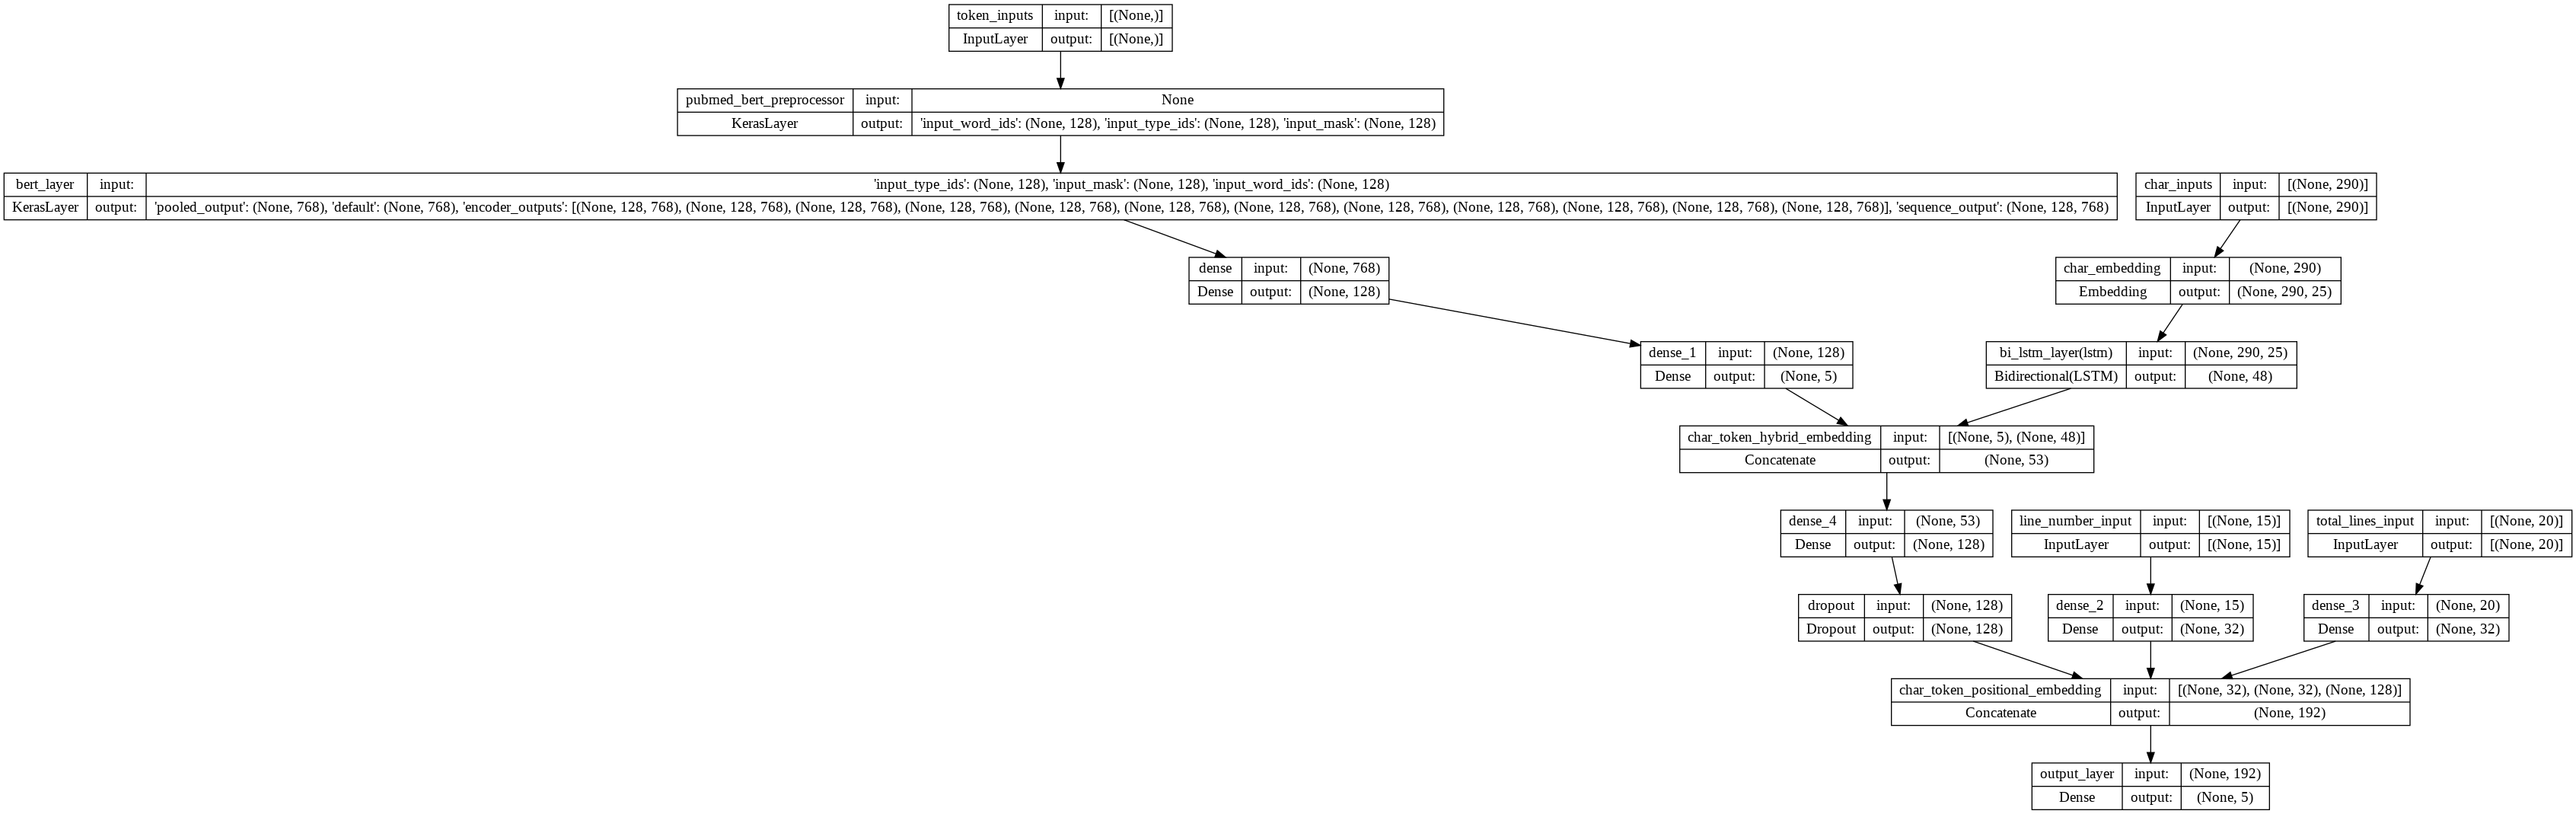

In [ ]:
tf.keras.utils.plot_model(bert_tribrid_model, show_shapes=True)

In [ ]:
# The input abstract was taken from https://pubmed.ncbi.nlm.nih.gov/32537182/
abstract_text = "Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken."
dataset = preprocessor(abstract_text)
# Create prediction with loaded model on example data

bert_tribrid_model_pred_probs = bert_tribrid_model.predict(dataset)
bert_tribrid_model_preds = tf.argmax(bert_tribrid_model_pred_probs, axis=1)

# Make sure the model return the appropiate output
len(bert_tribrid_model_preds), len(dataset[2])

1/1 [==============================] - 0s 47ms/step


(13, 13)

In [ ]:
# Visualize the prediction
for i, line in zip(bert_tribrid_model_preds, dataset[2]):
  print(f"{class_names[i]}: {line}")

BACKGROUND: b'Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death.'
BACKGROUND: b'Recently, a shift toward up-front maximal safe resection of DLGGs has been favored.'
BACKGROUND: b'However, this transition is not supported by randomized controlled trial (RCT) data.'
BACKGROUND: b'Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.'
METHODS: b'A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons.'
METHODS: b'A sample case of a patient for whom management might be debatable was presented to gather additional insight.'
RESULTS: b'The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected.'
RESULTS: b'Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 o

### Tribrid Model

In [ ]:
tribrid_model = tf.keras.models.load_model('/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/tribrid_model_all_data',
                                        custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# The input abstract was taken from https://pubmed.ncbi.nlm.nih.gov/32537182/
abstract_text = "Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken."
dataset = preprocessor(abstract_text)
# Create prediction with loaded model on example data

tribrid_model_pred_probs = tribrid_model.predict(dataset)
tribrid_model_preds = tf.argmax(tribrid_model_pred_probs, axis=1)

# Make sure the model return the appropiate output
len(tribrid_model_preds), len(dataset[2])

1/1 [==============================] - 9s 9s/step


(13, 13)

In [ ]:
# Visualize the prediction
for i, line in zip(tribrid_model_preds, dataset[2]):
  print(f"{class_names[i]}: {line}")

BACKGROUND: b'Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death.'
BACKGROUND: b'Recently, a shift toward up-front maximal safe resection of DLGGs has been favored.'
BACKGROUND: b'However, this transition is not supported by randomized controlled trial (RCT) data.'
BACKGROUND: b'Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.'
METHODS: b'A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons.'
RESULTS: b'A sample case of a patient for whom management might be debatable was presented to gather additional insight.'
RESULTS: b'The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected.'
RESULTS: b'Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 o

### Daniel Tribrid Model

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

--2023-01-31 07:30:14--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  41.1MB/s    in 24s     

2023-01-31 07:30:39 (38.2 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]



In [ ]:
from helper_functions import unzip_data
unzip_data("skimlit_tribrid_model.zip")

In [ ]:
import tensorflow_hub as hub
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model", custom_objects={"KerasLayer": hub.KerasLayer})

AssertionError: ignored

### Bert tribrid char vectorizer

In [ ]:
# Dependencies
!pip install --quiet tensorflow-text==2.9.0 # specify version to avoid error

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.(important in order to load the model)
from tensorflow.keras import layers

In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        6.0.0
blis  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
load_option = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
model = tf.keras.models.load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/bert_tribrid_model_char_vectorizer",
                                   custom_objects={"KerasLayer":hub.KerasLayer},
                                   options=load_option)

In [ ]:
model_pred_probs = model.predict(dataset)
model_preds = tf.argmax(model_pred_probs, axis=1)

# Make sure the model return the appropiate output
len(model_preds), len(dataset[2])

1/1 [==============================] - 0s 54ms/step


(13, 13)

In [ ]:
# The input abstract was taken from https://pubmed.ncbi.nlm.nih.gov/32537182/
abstract_text = "Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken."
dataset = preprocessor(abstract_text)

In [ ]:
import pandas as pd
def preprocessor(abstract_text):
  sample = preprocess_text_with_line_numbers(abstract_text) 
  df = pd.DataFrame(sample)
  # Sentence and character level
  sentences = df["text"].tolist()
  chars = [split_chars(sentence) for sentence in sentences]
  chars_vectorized = char_vectorization(chars)
  # Positional embeddings
  line_numbers_one_hot = tf.one_hot(df["line_number"].to_numpy(), depth=15) # depth same as the model was trained on
  total_lines_one_hot = tf.one_hot(df["total_lines"].to_numpy(), depth=20)

  dataset = [line_numbers_one_hot,
             total_lines_one_hot,
             tf.constant(sentences),
             tf.constant(chars)]
  
  return dataset

# The input abstract was taken from https://pubmed.ncbi.nlm.nih.gov/32537182/
abstract_text = "Diffuse low-grade gliomas (DLGGs) are heterogeneous tumors that inevitably differentiate into malignant entities, leading to disability and death. Recently, a shift toward up-front maximal safe resection of DLGGs has been favored. However, this transition is not supported by randomized controlled trial (RCT) data. Here, we sought to survey the neuro-oncology community on considerations for a surgical RCT for DLGGs.A 21-question survey focusing on a surgical RCT for DLGGs was developed and validated by 2 neurosurgeons. A sample case of a patient for whom management might be debatable was presented to gather additional insight. The survey was disseminated to members of the Society for Neuro-Oncology (SNO) and responses were collected from March 16 to July 10, 2018.A total of 131 responses were collected. Sixty-three of 117 (54%) respondents thought an RCT would not be ethical, 39 of 117 (33%) would consider participating, and 56 of 117 (48%) believed an RCT would be valuable for determining the differing roles of biopsy, surgery, and observation. This was exemplified by an evenly distributed selection of the latter management options for our sample case. Eighty-three of 120 (69.2%) respondents did not believe in equipoise for DLGG patients. Quality of life and overall survival were deemed equally important end points for a putative RCT.Based on our survey, it is evident that management of certain DLGG patients is not well defined and an RCT may be justified. As with any surgical RCT, logistic challenges are anticipated. Robust patient-relevant end points and standardization of perioperative adjuncts are necessary if a surgical RCT is undertaken."
dataset = preprocessor(abstract_text)

In [ ]:
import spacy
import tensorflow as tf

# Function to get abstract line information
def preprocess_text_with_line_numbers(abstract_text):
  
  nlp = spacy.load("en_core_web_sm") # setup english sentence parser 
  doc = nlp(abstract_text) # create "doc" of parsed sequences
  abstract_lines = [str(sent) for sent in list(doc.sents)] # list of line on string (not spaCy type)

  # Create list of dictionaries containing features for each line
  total_lines_in_sample = len(abstract_lines) # get total number of lines 

  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i 
    sample_dict['total_lines'] = total_lines_in_sample - 1 
    sample_lines.append(sample_dict)   
      
  return sample_lines

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Function to vectorized character sentence
import string
from tensorflow.keras.layers import TextVectorization

def char_vectorization(chars):
  # Define the parameter
  alphabet = string.ascii_lowercase + string.digits + string.punctuation
  NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, "[UNK]")
  output_sequence_length = 290 # same as the model trained on

  # Instantiate TextVectorizer
  char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                      output_sequence_length=output_sequence_length)
  char_vectorizer.adapt(chars) # learn the pattern on data

  chars_vectorized = char_vectorizer(chars)

  return chars_vectorized

# Unique labels
class_names = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']